# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to push the car to the mountaintop on the right.

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0.6 & 0 
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The initial position is within $[-0.6, -0.4]$.

In [11]:
%matplotlib inline

import importlib



In [12]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/'))


import random
import ilqr
import math

In [13]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [14]:
from ilqr import iLQR
from ilqr.cost import PathQRCost, QRCost
from ilqr.examples.car import MountaincarDynamics, CarCost
from ilqr.dynamics import constrain


# from bc import *
from ppo import *
import pickle
import gym

import argparse
from utils import *

from torch import nn
from itertools import count



In [15]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    if iteration_count % 30 == 0:
        print("iteration", iteration_count, info, J_opt, final_state)

In [16]:
# Define gym environment
#env = gym.make('MountainCar-v0')
env = gym.make('MountainCarContinuous-v0')


device = 'cuda' if torch.cuda.is_available else 'cpu'

importlib.reload(ilqr)
dynamics = MountaincarDynamics()

# Train initial policy


dtype = torch.float64
torch.set_default_dtype(dtype)
is_disc_action = len(env.action_space.shape) == 0
state_dim = env.observation_space.shape[0]

policy_net, _, running_state = pickle.load(open(\
"/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCarContinuous-v0_ppo.p", "rb"))

agent = NeuralNetwork(input_size = 2, output_size = 1, model_name = 'mountaincar_ppo', batch_size = 10)
agent.model = policy_net.to(device)



'''
policy_net, _, running_state = pickle.load(open(\
"/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCar-v0_ppo.p", "rb"))

########################## Find mean and std or x, v to omit running_state()
def check_statistics():
    xs = np.linspace(-1.2, 0.6, 10000)
    vs = np.linspace(-0.07, 0.07, 10000)
    xs_ = []
    vs_ = []
    x_std = 0.0
    v_std = 0.0

    for v in vs:
        x_std += 1.8/(running_state([0.6, v]) - running_state([-1.2, v]))[0]
        vs_.append(np.abs(running_state([-0.6, v])[1]))
    for x in xs:
        v_std += 0.14/(running_state([x, 0.07]) - running_state([x, -0.07]))[1]
        xs_.append(np.abs(running_state([x, 0.0])[0]))

    x_mean = xs[np.argmin(xs_)]
    v_mean = vs[np.argmin(vs_)]
    x_std = x_std/len(xs_)
    v_std = v_std/len(vs_)
    print(x_mean, v_mean, x_std, v_std)

    print(running_state([-0.6, 0.0]))
    print((np.array([-0.6, 0.0]) - np.array([x_mean, v_mean]))/np.array([x_std, v_std]))
    return x_mean, v_mean, x_std, v_std
'''



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


'\npolicy_net, _, running_state = pickle.load(open("/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCar-v0_ppo.p", "rb"))\n\n########################## Find mean and std or x, v to omit running_state()\ndef check_statistics():\n    xs = np.linspace(-1.2, 0.6, 10000)\n    vs = np.linspace(-0.07, 0.07, 10000)\n    xs_ = []\n    vs_ = []\n    x_std = 0.0\n    v_std = 0.0\n\n    for v in vs:\n        x_std += 1.8/(running_state([0.6, v]) - running_state([-1.2, v]))[0]\n        vs_.append(np.abs(running_state([-0.6, v])[1]))\n    for x in xs:\n        v_std += 0.14/(running_state([x, 0.07]) - running_state([x, -0.07]))[1]\n        xs_.append(np.abs(running_state([x, 0.0])[0]))\n\n    x_mean = xs[np.argmin(xs_)]\n    v_mean = vs[np.argmin(vs_)]\n    x_std = x_std/len(xs_)\n    v_std = v_std/len(vs_)\n    print(x_mean, v_mean, x_std, v_std)\n\n    print(running_state([-0.6, 0.0]))\n    print((np.array([-0.6, 0.0]) - np.array([x_mean, v_mean]))/np

In [17]:
def nn_main_loop(num_episodes):

    
    for i_episode in range(num_episodes):
        #x_mean, v_mean, x_std, v_std = check_statistics()
        num_steps = 0
        state = env.reset()
        reward = 0.0
        done = False
        state = running_state(state)
        reward_episode = 0
        max_spd = 0.0
        
        
        while True:
            state_var = tensor(state).unsqueeze(0).to(dtype)
           
           
            """
            # choose stochastic action
            if is_disc_action:
                action = policy_net.select_action(state_var)[0].cpu().numpy()
            else:
                #action = policy_net(state_var)[0][0].detach().numpy()
                # If using disc net in continuous env
                action_probs = policy_net(state_var)[0].detach().cpu().numpy()
                actions = np.arange(0, 3).astype(np.float64)
                action = np.asarray([action_probs.dot(actions)])
            
            """ 
            # choose mean action
            #action = policy_net(state_var).detach().cpu().numpy()[0]
            action = agent.run(tensor([state]).cuda())[0]
            action = int(action) if is_disc_action else action.astype(np.float64)
            
            next_state, reward, done, _ = env.step(action)
            max_spd = next_state[-1] if max_spd < abs(next_state[-1]) else max_spd
            #next_state = running_state(next_state)
            #next_state = (next_state - np.array([x_mean, v_mean]))/np.array([x_std, v_std])
            reward_episode += reward
            num_steps += 1

            
            env.render()
            if done or num_steps >= 200:
                print(num_steps, next_state)
                break

            state = next_state

        print('Episode {}\t reward: {:.2f}\t max_speed: {:.2f}'.format(i_episode, reward_episode, max_spd))

    env.close()

nn_main_loop(1)


155 [0.46288333 0.03604353]
Episode 0	 reward: 72.57	 max_speed: 0.04


# The specification is
=====================
###### The car velocity should never exceed 0.05 at all time ##############
###### The car velocity should never exceed 0.03 at the top of the mountaintop on the right

In [18]:
# Define goal state where only the position matters 
def goal():
    return np.array([0.6, 0.07])

# Define upper bound barrier where both the position and velocity is the maximum
def barrier_u(x):
    if x[0] >= 0.4:
        return np.array([10.0, 0.025])
    else:
        return np.array([10.0, 0.07])
# Define lower bound barrier where both the position and velocity is the minimum    
def barrier_l(x):
    if x[0] >= 0.4:
        return np.array([-10.0, -0.07])
    else:
        return np.array([-10.0, -0.07])

# Define the nominal as being equal to the current state
def nominal(x):
    return goal()

N = 200
x_nominal = 200 * [goal()] 

Experiments on using iLQR in finishing the task all fail
=============

In [19]:
'''
# Directly running iLQR does not help solve the problem because mountaincar is complicated
# Standard iLQR initialization
# Quadratic state cost is zero
Q = 10.0 * np.eye(dynamics.state_size)
R = 0.0 * np.eye(dynamics.action_size)
q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 

# The quadratic barrier cost is nonzero
A = np.array([[[0, 1.]], [[0, -1.]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 10.0]
q2 = [150.0, 10.0]

# Define the cost functions
cost = CarCost(Q, q, R, r, A, b, q1, q2, x_nominal, barrier_u, barrier_l)
# Define the initial state and control sequence
x0 = env.reset()
us_init = np.random.uniform(0, 2, (N, dynamics.action_size))
# Define the iLQR controller
ilqr = iLQR(dynamics, cost, N)

env.close()
state = env.reset()
reward = 0.0
done = False

J_hist = []
step_len = 1
n = 10
n_iterations = 100
assert n > step_len, "MPC horizon must be longer than step length."
for step in range(int(200/step_len)): 
    x0 = dynamics.augment_state(state)
    us_init = np.random.uniform(0, 2, (n , dynamics.action_size))
    us_init = np.zeros((n, dynamics.action_size))
    ilqr = iLQR(dynamics, cost, n)
    xs, us = ilqr.fit(x0, us_init, n_iterations = n_iterations, on_iteration=on_iteration)
    us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)
    us = us[0: step_len]
    us = (us > 0.0).astype(int)
    for sub_step in range(step_len):
        u = us[sub_step]
        print(step * step_len + sub_step, state, u, reward, done)
        state, reward, done, _ = env.step(u)
        env.render()
        if done is True:
            env.close()
            raise ValueError('Done')
env.close()         

'''

'\n# Directly running iLQR does not help solve the problem because mountaincar is complicated\n# Standard iLQR initialization\n# Quadratic state cost is zero\nQ = 10.0 * np.eye(dynamics.state_size)\nR = 0.0 * np.eye(dynamics.action_size)\nq = np.zeros((dynamics.state_size, 1))\nr = np.zeros((dynamics.action_size, 1)) \n\n# The quadratic barrier cost is nonzero\nA = np.array([[[0, 1.]], [[0, -1.]]])\nb = np.array([[-0.0], [0.0]])\nq1 = [150.0, 10.0]\nq2 = [150.0, 10.0]\n\n# Define the cost functions\ncost = CarCost(Q, q, R, r, A, b, q1, q2, x_nominal, barrier_u, barrier_l)\n# Define the initial state and control sequence\nx0 = env.reset()\nus_init = np.random.uniform(0, 2, (N, dynamics.action_size))\n# Define the iLQR controller\nilqr = iLQR(dynamics, cost, N)\n\nenv.close()\nstate = env.reset()\nreward = 0.0\ndone = False\n\nJ_hist = []\nstep_len = 1\nn = 10\nn_iterations = 100\nassert n > step_len, "MPC horizon must be longer than step length."\nfor step in range(int(200/step_len)): \

* Try Neural Network and MPSC as safe controller

In [22]:
env.close()
J_hist = []
# Quadratic state cost is zero
Q = 0.0 * np.eye(dynamics.state_size)
R = 0.0 * np.eye(dynamics.action_size)
q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 

# The quadratic barrier cost is nonzero
A = np.array([[[0, 1.]], [[0, -1.]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 10.0]
q2 = [150.0, 10.0]

N = len(x_nominal)

n = 100
n_init = 0
#n_end = 250
n_end = N

# Initial state.
# x0s = [[0.1 * (2 * random.random() - 1) - 0.5, 0.01 * (2 * random.random() - 1)] for i in range(1)]
x0s = [[]]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))


def MPSC(agent, x0s):

    train_trajs = []
    nn_trajs = []
    mpc_trajs= []
    trajs = []
    for num in range(len(x0s)):        
        train_trajs.append([])
        nn_trajs.append([])
        mpc_trajs.append([])
        trajs.append([])
        
        
        x0 = env.reset()
        if x0s[num] == []:
            x0s[num] = x0
        else:
            env.state = np.array(x0s[num])
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            if ((x0 - barrier_u(x0)).dot(A[0].T) - b[0, 0] > 0).any() or \
            ((x0 - barrier_l(x0)).dot(A[1].T) - b[1, 0] > 0).any():
                
                print("Unsafe")
                return  trajs, nn_trajs, mpc_trajs, train_trajs 
            
            #u0 = policy_net(tensor(x0).unsqueeze(0).to(dtype)).detach().cpu().numpy()[0]
            u0 = agent.run(tensor([x0]).cuda())[0]
            #print("NN outputs control")
            #nn_trajs[-1] = nn_trajs[-1] + [[x0[:], u0[:]]]
            x1 = dynamics.f(x0, u0, step)[0]
            
   
            if step <= n_end - n - 1:
                n_ilqr =  n 
            elif step + 1 < n_end - 1:
                n_ilqr = n_end - 1 - step
            else:
                trajs[-1].append([x0, u0[:]])
                nn_trajs[-1].append(trajs[-1][-1])
                break

            print("NN verification via simulation")
            x0_ = x1[:]
            us_ = []
            xs_ = []
            for i_ in range(n_ilqr - 1):
                u0_ = agent.run(tensor([x0_]).cuda())[0]
                xs_.append(x0_[:])
                us_.append(u0_[:])
                x1_ = dynamics.f(x0_, u0_, i_ + step + 1)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze((xs_ - np.asarray([barrier_u(x) for x in xs_])).dot(A[0].T) - b[0,0] \
                           <= 0)).all() == True and \
                (np.squeeze((xs_ - np.asarray([barrier_l(x) for x in xs_])).dot(A[1].T) - b[1,0] \
                            <= 0)).all() == True:
                trajs[-1].append([x0, u0[:]])
                nn_trajs[-1].append(trajs[-1][-1])
                #train_traj[-1].append([x_nn, u[0, :]])
                print("Utilize NN output {}".format(u0))
            else: 
                print("MPC feasibility verification")
                x_nominal_ilqr = x_nominal[step + 1: step + 1 + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))
                us_init = np.zeros((n_ilqr - 1 - 1, dynamics.action_size))
                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:-1], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1 - 1)
                try:
                    xs, us = ilqr_.fit(x1, us_init, on_iteration=on_iteration)
                except:
                    print(e)
                    return trajs, nn_trajs, mpc_trajs, train_trajs
                    us = np.clip(us, 0.0, 2.0)
                
                if (np.squeeze((xs - np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze((xs - np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    trajs[-1].append([x0, u0[:]])
                    nn_trajs[-1].append(trajs[-1][-1])
                    train_trajs[-1].append([x0, u0[:]])
                    print("Utilize NN output {}".format(u0))
                else:
                    print("MPC synthesization")
                    
                    max_itr = 0
                    us_init = np.zeros((n_ilqr - 1, dynamics.action_size))
                    while (np.squeeze((xs - np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == False or \
                          (np.squeeze((xs - np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - b[1,0]\
                               <= 0)).all() == False :
                        print("Failed to find safe trajectory")
                        
                        if max_itr == 50:
                            #break
                            return  trajs, nn_trajs, mpc_trajs, train_trajs
                        max_itr += 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, n_iterations = max_itr * 10, on_iteration=on_iteration)
                        #us_init = us
                       
                        us = np.clip(us, 0.0, 2.0)
                        
                    trajs[-1].append([x0, us[0]])
                    mpc_trajs[-1].append(trajs[-1][-1])
                    train_trajs[-1].append([x0, us[0]])
                    x1 = dynamics.f(x0, us[0], step)[0]
                    print("Utilize MPC output {}".format(us[0]))

            
            
            state, _, _, _ = env.step(trajs[-1][-1][-1])
            env.render()
            
            print(state)
            #x0 = state
            
            print(x1)
            x0 = x1[:]
            
            
            
            
            
    return  trajs, nn_trajs, mpc_trajs, train_trajs

trajs, nn_trajs, mpc_trajs, train_trajs = MPSC(agent, x0s)



       

>>>>>Step 0 at [-0.43689458  0.        ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14212.43223641] [-0.36776988  0.00927965]
Utilize NN output [0.20239096]
[-4.37233963e-01 -3.39386972e-04]
[-0.43873396 -0.00183939]
>>>>>Step 1 at [-0.43873396 -0.00183939]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14209.10649005] [-0.39549466  0.00872465]
Utilize NN output [0.00386846]
[-0.43820806 -0.0009741 ]
[-0.44269718 -0.00396322]
>>>>>Step 2 at [-0.44269718 -0.00396322]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14204.8914083] [-0.42521013  0.00807482]
Utilize NN output [0.00079009]
[-0.43981442 -0.00160636]
[-0.44876003 -0.00606285]
>>>>>Step 3 at [-0.44876003 -0.00606285]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14199.72336976] [-0.45665778  0.00714411]
Utilize NN output [0.00134397]
[-0.44204055 -0.00222613]
[-0.45687746 -0.0081174

MPC feasibility verification
iteration 0 accepted [-14196.87485563] [-0.47892474 -0.00488657]
Utilize NN output [1.99993081]
[-0.57273625  0.00811833]
[-1.0172116   0.00333748]
>>>>>Step 35 at [-1.0172116   0.00333748]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14201.60554368] [-0.49985819 -0.00687113]
Utilize NN output [1.99996021]
[-0.56275073  0.00998553]
[-1.00988429  0.00732731]
>>>>>Step 36 at [-1.00988429  0.00732731]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14202.04973739] [-0.50563729 -0.01409407]
Utilize NN output [1.99992511]
[-0.55097223  0.01177849]
[-0.99857275  0.01131155]
>>>>>Step 37 at [-0.99857275  0.01131155]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14196.08632762] [-0.48281267 -0.01909213]
Utilize NN output [1.99974173]
[-0.53748867  0.01348356]
[-0.98328814  0.01528461]
>>>>>Step 38 at [-0.98328814  0.01528461]
NN verification via simulation


MPC synthesization
Failed to find safe trajectory
iteration 0 failed -9855.929266753668 [-1.2        -0.03842394]
Utilize MPC output [0.]
[-0.01287998  0.00451264]
[0.30496559 0.03485241]
>>>>>Step 66 at [0.30496559 0.03485241]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -1152.4422531461696 [-1.2        -0.04527103]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -9876.410550103588 [-1.2        -0.03768204]
Utilize MPC output [0.]
[-0.01086547  0.00201451]
[0.33679332 0.03182773]
>>>>>Step 67 at [0.33679332 0.03182773]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -5856.393371441371 [-1.2        -0.04411477]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -9883.765688391604 [-1.2        -0.03694015]
Utilize MPC output [0.]
[-0.01134964 -0.00048416]
[0.3657922  0.02899888]
>>>>>Step 68 at [0.3657922  0.02899888]
NN verification via simulation
MPC feasibility verification
iterati

iteration 0 failed -3266.8601330183983 [-1.2        -0.04664211]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -6782.734491544915 [-1.2        -0.04446292]
Utilize MPC output [0.]
[-0.57530422 -0.03183251]
[0.6       0.0226801]
>>>>>Step 94 at [0.6       0.0226801]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -5207.498320820463 [-1.2        -0.04588956]
Utilize NN output [1.80740901]
[-0.6052505  -0.02994628]
[0.6        0.02445922]
>>>>>Step 95 at [0.6        0.02445922]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -1141.314343843791 [-1.2        -0.04731082]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -5345.239932178518 [-1.2        -0.04514767]
Utilize MPC output [0.]
[-0.63459049 -0.02933999]
[0.6        0.02352723]
>>>>>Step 96 at [0.6        0.02352723]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -3459.9214751492577 [-1.2        -0

iteration 0 failed -2020.0509296024595 [-1.2        -0.06159421]
Utilize MPC output [0.]
[-0.64379092  0.02745581]
[0.6        0.02370741]
>>>>>Step 122 at [0.6        0.02370741]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 62.72051011571495 [-1.2        -0.06376985]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -3510.9339490799325 [-1.2        -0.06159421]
Utilize MPC output [0.]
[-0.61545307  0.02833785]
[0.6        0.02277542]
>>>>>Step 123 at [0.6        0.02277542]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -1779.6782733316413 [-1.2        -0.06376041]
Utilize NN output [1.80844196]
[-0.584935    0.03051807]
[0.6        0.02455609]
>>>>>Step 124 at [0.6        0.02455609]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 2495.360365741939 [-1.1455136 -0.0660967]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -1779.6782733316413 [-1.2     

MPC synthesization
Failed to find safe trajectory
iteration 0 accepted [187.45317477] [ 0.45344141 -0.00331082]
Utilize MPC output [0.]
[-0.02665362  0.00261707]
[0.6        0.02295182]
>>>>>Step 149 at [0.6        0.02295182]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [2024.13490953] [0.5448777  0.00421223]
Utilize NN output [1.81030126]
[-0.02502856  0.00162506]
[0.6        0.02473528]
>>>>>Step 150 at [0.6        0.02473528]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [6485.12851639] [ 0.53709626 -0.00054128]
MPC synthesization
Failed to find safe trajectory
iteration 0 accepted [2024.13490953] [0.5448777  0.00421223]
Utilize MPC output [0.]
[-0.02589646 -0.0008679 ]
[0.6        0.02380329]
>>>>>Step 151 at [0.6        0.02380329]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [4166.10908971] [ 5.37096457e-01 -5.24552479e-04]
MPC synthesization
Failed to find safe trajectory


MPC synthesization
Failed to find safe trajectory
iteration 0 converged [6062.54399859] [0.6        0.00440726]
Utilize MPC output [0.]
[-0.61426225 -0.02984923]
[0.6        0.02397915]
>>>>>Step 177 at [0.6        0.02397915]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 8238.669706243872 [0.6        0.00713711]
MPC synthesization
Failed to find safe trajectory
iteration 0 converged [4475.08307645] [0.6        0.00440726]
Utilize MPC output [0.]
[-0.64343985 -0.0291776 ]
[0.6        0.02304716]
>>>>>Step 178 at [0.6        0.02304716]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 6279.91302025056 [0.6        0.00712418]
Utilize NN output [1.81127854]
[-0.67023789 -0.02679803]
[0.6        0.02483208]
>>>>>Step 179 at [0.6        0.02483208]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 10730.638891738969 [0.6        0.00986392]
MPC synthesization
Failed to find safe trajectory
iteration 0

In [23]:

def replay(agent, trajs):
    for i_traj in range(len(trajs)):
        env.close()
        env.reset()
        env.state = trajs[i_traj][0][0]
        
        state = env.state
        for _ in range(200):
            action = agent.run(tensor([state]).cuda())[0]
            state, _, done, _ = env.step(action)
            print(state)

            env.render()
            #if done:
            #    break

        env.close()
print(len(trajs[0]))
replay(agent, trajs)
                                                

199
[-5.21869487e-01  2.92812905e-04]
[-0.52008964  0.00177984]
[-0.51683612  0.00325353]
[-0.51213331  0.00470281]
[-0.50601647  0.00611683]
[-0.49853145  0.00748503]
[-0.48973424  0.0087972 ]
[-0.47969059  0.01004365]
[-0.4684753   0.01121529]
[-0.45617155  0.01230375]
[-0.44287006  0.01330149]
[-0.42866814  0.01420192]
[-0.41366861  0.01499953]
[-0.39797869  0.01568992]
[-0.38213684  0.01584186]
[-0.36705627  0.01508057]
[-0.35302598  0.01403029]
[-0.34019008  0.0128359 ]
[-0.32864799  0.01154209]
[-0.31848014  0.01016785]
[-0.30975241  0.00872773]
[-0.30251866  0.00723374]
[-0.29682235  0.00569631]
[-0.29269704  0.00412532]
[-0.29016665  0.00253038]
[-0.2892458   0.00092085]
[-0.28993995 -0.00069415]
[-0.2922455  -0.00230556]
[-0.29614975 -0.00390425]
[-0.30163041 -0.00548066]
[-0.30865547 -0.00702505]
[-0.31718316 -0.00852769]
[-0.3271619  -0.00997874]
[-0.33853009 -0.0113682 ]
[-0.35121608 -0.01268599]
[-0.36513807 -0.01392199]
[-0.38020424 -0.01506617]
[-0.39631299 -0.01610875]


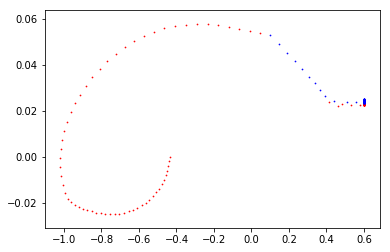

In [24]:
def draw_trajs(trajs, colors = None):
    if colors is None:
        colors = ['r'] * len(trajs)
    for i_traj in range(len(trajs)):
        poss = [xy[0][0] for xy in trajs[i_traj]]
        vs = [xy[0][1] for xy in trajs[i_traj]]
        
        
        _ = plt.scatter(poss, vs, s = 0.5, c = colors[i_traj])
    plt.show()
    
draw_trajs([nn_trajs[0], mpc_trajs[0]], ['r', 'b'])

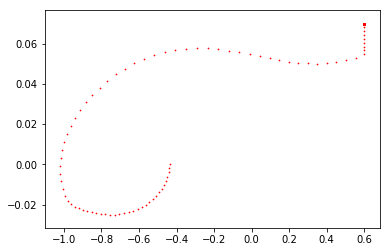

In [25]:
def agent_run(agent, x0s):
    agent_trajs = []
    for i_x0 in range(len(x0s)):
        agent_trajs.append([])
        x = x0s[i_x0]

        for step in range(200):
            u = agent.run(tensor([x]).cuda())[0]
            #u = policy_net(tensor(x).unsqueeze(0).to(dtype)).detach().cpu().numpy()[0]
            agent_trajs[-1].append([x[:], u])
            x = dynamics.f(x, u, step)[0]        
    return agent_trajs

agent_trajs = agent_run(agent, x0s)
draw_trajs(agent_trajs)

198
[Epoch 1] avg_loss: 0.644
[Epoch 51] avg_loss: 0.563
Finished Training


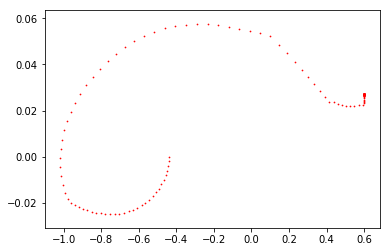

>>>>>Step 0 at [-0.58578614  0.        ]
NN verification via simulation


/home/depend/virtualenv_py3/lib/python3.5/site-packages/ipykernel_launcher.py:44: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Utilize NN output [1.99980238]
[-0.58382244  0.0019637 ]
[-0.58382274  0.00196341]
>>>>>Step 1 at [-0.58382274  0.00196341]
NN verification via simulation
Utilize NN output [1.99944866]
[-0.57990951  0.00391293]
[-0.57991093  0.00391181]
>>>>>Step 2 at [-0.57991093  0.00391181]
NN verification via simulation
Utilize NN output [1.9991501]
[-0.57407626  0.00583325]
[-0.57408006  0.00583087]
>>>>>Step 3 at [-0.57408006  0.00583087]
NN verification via simulation
Utilize NN output [1.99987129]
[-0.56636587  0.00771039]
[-0.56637222  0.00770784]
>>>>>Step 4 at [-0.56637222  0.00770784]
NN verification via simulation
Utilize NN output [1.99999883]
[-0.55683561  0.00953026]
[-0.55684446  0.00952776]
>>>>>Step 5 at [-0.55684446  0.00952776]
NN verification via simulation
Utilize NN output [1.99999998]
[-0.54555648  0.01127913]
[-0.54556778  0.01127669]
>>>>>Step 6 at [-0.54556778  0.01127669]
NN verification via simulation
Utilize NN output [2.]
[-0.53261279  0.01294369]
[-0.53262644  0.012941

Utilize NN output [0.99999995]
[0.05192258 0.00467307]
[-0.02583629 -0.0084798 ]
>>>>>Step 42 at [-0.02583629 -0.0084798 ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14167.40546066] [-0.13470004 -0.01718627]
Utilize NN output [0.99999966]
[0.05562592 0.00370334]
[-0.03680859 -0.0109723 ]
>>>>>Step 43 at [-0.03680859 -0.0109723 ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14163.72042058] [-0.13791263 -0.01833986]
Utilize NN output [0.99999716]
[0.05836399 0.00273807]
[-0.05026566 -0.01345707]
>>>>>Step 44 at [-0.05026566 -0.01345707]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14160.35275653] [-0.12869219 -0.01909242]
Utilize NN output [0.99993782]
[0.06014018 0.0017762 ]
[-0.06619446 -0.0159288 ]
>>>>>Step 45 at [-0.06619446 -0.0159288 ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14157.68941345] [-0.10080993 -0.01916147]
Utilize 

iteration 0 accepted [-14227.03237014] [-0.2371704  -0.00817218]
Utilize NN output [1.74104448]
[-0.66381953 -0.03416358]
[-1.2        -0.03287051]
>>>>>Step 76 at [-1.2        -0.03287051]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14226.63578207] [-0.25241662 -0.00908118]
Utilize NN output [1.78177126]
[-0.6954622  -0.03164267]
[-1.2        -0.02945596]
>>>>>Step 77 at [-1.2        -0.02945596]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14222.48834963] [-0.27438595 -0.01012474]
Utilize NN output [1.90209681]
[-0.72437225 -0.02891005]
[-1.2        -0.02586092]
>>>>>Step 78 at [-1.2        -0.02586092]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14217.95465248] [-0.29602879 -0.01110086]
Utilize NN output [1.97090238]
[-0.75036591 -0.02599366]
[-1.2        -0.02216267]
>>>>>Step 79 at [-1.2        -0.02216267]
NN verification via simulation
MPC feasibility verification


iteration 0 failed 5482.265492893611 [-1.2       -0.0505183]
Utilize MPC output [0.]
[-0.10211712  0.04073418]
[-0.07218317  0.0643507 ]
>>>>>Step 110 at [-0.07218317  0.0643507 ]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 9247.511019992446 [-1.2        -0.06151692]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -1575.0549357126129 [-1.2       -0.0505183]
Utilize MPC output [0.]
[-0.06376653  0.03835058]
[-0.01177408  0.06040908]
>>>>>Step 111 at [-0.01177408  0.06040908]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 5562.024184760195 [-1.2        -0.06110608]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -5105.815401613381 [-1.2       -0.0505183]
Utilize MPC output [0.]
[-0.02787035  0.03589619]
[0.04463656 0.05641064]
>>>>>Step 112 at [0.04463656 0.05641064]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3443.3785740771073 [-1.2        -0.0

[0.3814997  0.00700287]
[0.6        0.02479675]
>>>>>Step 142 at [0.6        0.02479675]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [2334.07387152] [ 0.42488148 -0.00987896]
MPC synthesization
Failed to find safe trajectory
iteration 0 accepted [985.50605343] [ 0.40880686 -0.01292457]
Utilize MPC output [0.]
[0.38746882 0.00596911]
[0.6        0.02386476]
>>>>>Step 143 at [0.6        0.02386476]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [572.88057742] [ 0.42488059 -0.00987906]
Utilize NN output [1.00018203]
[0.3939451  0.00647628]
[0.6        0.02443303]
>>>>>Step 144 at [0.6        0.02443303]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [1833.39806435] [ 0.44528016 -0.00661954]
MPC synthesization
Failed to find safe trajectory
iteration 0 accepted [572.88057742] [ 0.42488059 -0.00987906]
Utilize MPC output [0.]
[0.39947331 0.00552821]
[0.6        0.02350104]
>>>>>Step 145 

MPC synthesization
Failed to find safe trajectory
iteration 0 failed 5098.403495201291 [ 5.99610014e-01 -3.89985556e-04]
Utilize MPC output [0.]
[0.6        0.02784151]
[0.6        0.02384188]
>>>>>Step 172 at [0.6        0.02384188]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [4684.88868611] [0.6        0.00111029]
Utilize NN output [1.00018193]
[0.6        0.02990951]
[0.6        0.02441016]
>>>>>Step 173 at [0.6        0.02441016]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [5931.47373616] [0.6        0.00261058]
Utilize NN output [1.00019224]
[0.6        0.03197752]
[0.6        0.02497845]
>>>>>Step 174 at [0.6        0.02497845]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [7313.61932467] [0.6        0.00411092]
MPC synthesization
Failed to find safe trajectory
iteration 0 converged [5931.47373616] [0.6        0.00261058]
Utilize MPC output [0.]
[0.6        0.03254552]


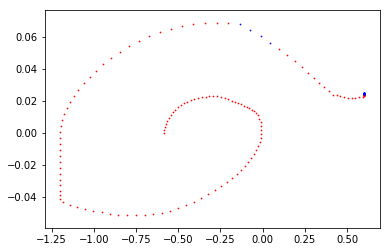

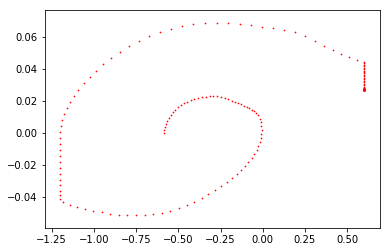

In [26]:
agent_temp = NeuralNetwork(input_size = 2, output_size = 1, \
                           model_name = 'mountaincar_ppo_temp', \
                           batch_size = 10)
agent_temp.model = policy_net.to(device)
checkpoint_temp = torch.load('checkpoints/mountaincar_ppo.pt')
agent_temp.model.load_state_dict(checkpoint_temp['model_state_dict'], strict = False)


agent_temp.optimizer = torch.optim.Adam(agent_temp.model.parameters(), lr = 0.0001)

def train_pipeline(agent, train_trajs = None, paths = None, num_epoch = 100):

    x0s = []
    for i_traj in range(len(train_trajs)):
        x0s.append(train_trajs[i_traj][0][0])
     
    X = []
    Y = []
    
    if train_trajs is not None and train_trajs is not []:
        #print(len(train_trajs))
        for i_traj in range(len(train_trajs)):
            for i_xy in range(len(train_trajs[i_traj])):
                X.append([x for x in train_trajs[i_traj][i_xy][0]])
                Y.append([y for y in train_trajs[i_traj][i_xy][1]])
    agent.data_process(X = X, Y = Y, paths = paths)
    
    agent.train(num_epoch = num_epoch)
    #for i in range(len(X)):
    #    print(agent_.run([X[i]]), Y[i])

    agent_temp_trajs = agent_run(agent, x0s)    
    draw_trajs(agent_temp_trajs)
    
    # Random initial action path.

    J_hist = []

    trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = MPSC(agent, x0s)
    draw_trajs([nn_trajs_[0], mpc_trajs_[0]], ['r', 'b'])
    return trajs_, nn_trajs_, mpc_trajs_, train_trajs_ 

trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = train_pipeline(agent_temp, \
                                                             train_trajs = train_trajs, \
                                                             paths = None, \
                                                             num_epoch = 51)
x0s = []
for i_traj in range(len(trajs_)):
    x0s.append(trajs_[i_traj][0][0])
agent_trajs = agent_run(agent_temp, x0s)
draw_trajs(agent_trajs)

199
[Epoch 1] avg_loss: 0.221
[Epoch 51] avg_loss: 0.221
Finished Training


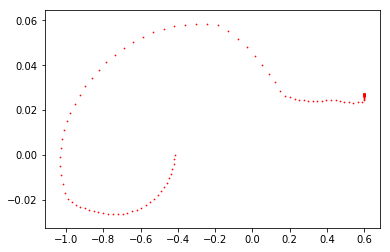

/home/depend/virtualenv_py3/lib/python3.5/site-packages/ipykernel_launcher.py:44: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


>>>>>Step 0 at [-0.41164624  0.        ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14211.79610346] [-0.37883198  0.00599451]
Utilize NN output [0.40142313]
[-4.11868056e-01 -2.21812743e-04]
[-0.41336806 -0.00172181]
>>>>>Step 1 at [-0.41336806 -0.00172181]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14210.36504878] [-0.38380974  0.00703788]
Utilize NN output [0.0522026]
[-0.41283394 -0.00096589]
[-0.41732331 -0.00395525]
>>>>>Step 2 at [-0.41732331 -0.00395525]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14206.11101679] [-0.41434329  0.00652309]
Utilize NN output [0.02605511]
[-0.41457628 -0.00174233]
[-0.42352311 -0.0061998 ]
>>>>>Step 3 at [-0.42352311 -0.0061998 ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14200.95772415] [-0.44629329  0.00577488]
Utilize NN output [0.02135029]
[-0.41708975 -0.00251348]
[-0.43193023 -0.0084071

MPC feasibility verification
iteration 0 accepted [-14197.92818285] [-0.47846342 -0.00632634]
Utilize NN output [1.99989481]
[-0.59137871  0.00708256]
[-1.03496563  0.002344  ]
>>>>>Step 35 at [-1.03496563  0.002344  ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14196.380136] [-0.48614534 -0.00526224]
Utilize NN output [1.9999565]
[-0.5822913   0.00908742]
[-1.02862338  0.00634225]
>>>>>Step 36 at [-1.02862338  0.00634225]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14202.77797329] [-0.50667004 -0.01009872]
Utilize NN output [1.99997712]
[-0.57126595  0.01102534]
[-1.01828505  0.01033833]
>>>>>Step 37 at [-1.01828505  0.01033833]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-14199.54498378] [-0.46820466 -0.0196684 ]
Utilize NN output [1.99999289]
[-0.55838433  0.01288163]
[-1.00395613  0.01432892]
>>>>>Step 38 at [-1.00395613  0.01432892]
NN verification via simulation
MPC

[-0.04085338  0.00044147]
[0.24952201 0.02431187]
>>>>>Step 68 at [0.24952201 0.02431187]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -13525.715895752963 [-1.2        -0.02319886]
Utilize NN output [1.9936571]
[-0.04139316 -0.00053977]
[0.27349271 0.02397069]
>>>>>Step 69 at [0.27349271 0.02397069]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -13524.844351384698 [-1.2        -0.02419247]
Utilize NN output [1.99313497]
[-0.04291368 -0.00152052]
[0.29724842 0.02375572]
>>>>>Step 70 at [0.29724842 0.02375572]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -13459.262069763901 [-1.2       -0.0253989]
Utilize NN output [1.98916219]
[-0.04541351 -0.00249983]
[0.32091774 0.02366932]
>>>>>Step 71 at [0.32091774 0.02366932]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -13226.954108185277 [-1.2        -0.02694881]
Utilize NN output [1.97435218]
[-0.04889018 -0.003

iteration 0 failed -3879.5464901958426 [-1.2        -0.04705611]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -5143.621033381158 [-1.2        -0.04591326]
Utilize MPC output [0.]
[-0.50668563 -0.02159925]
[0.6        0.02356158]
>>>>>Step 101 at [0.6        0.02356158]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -5522.875567826842 [-1.2        -0.04705609]
Utilize NN output [1.00004822]
[-0.52691167 -0.02022604]
[0.6        0.02412966]
>>>>>Step 102 at [0.6        0.02412966]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -4342.253207999111 [-1.2        -0.04827424]
Utilize NN output [1.00005471]
[-0.54561287 -0.01870119]
[0.6        0.02469774]
>>>>>Step 103 at [0.6        0.02469774]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -3029.1240516128946 [-1.2        -0.04947209]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -4342.253207999111 [

Utilize MPC output [0.]
[-0.45548432  0.02098462]
[0.6        0.02353517]
>>>>>Step 130 at [0.6        0.02353517]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -1671.7159687980195 [-0.90417257 -0.06933409]
Utilize NN output [1.00004806]
[-0.433507    0.02197731]
[0.6        0.02410325]
>>>>>Step 131 at [0.6        0.02410325]
NN verification via simulation
MPC feasibility verification
iteration 0 failed -507.74207726770277 [-0.79292276 -0.07      ]
Utilize NN output [1.00005424]
[-0.41069718  0.02280982]
[0.6        0.02467134]
>>>>>Step 132 at [0.6        0.02467134]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 788.5276458375068 [-0.67943417 -0.07      ]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed -507.74207726770277 [-0.79292276 -0.07      ]
Utilize MPC output [0.]
[-0.38871802  0.02197916]
[0.6        0.02373934]
>>>>>Step 133 at [0.6        0.02373934]
NN verification via simulation
MPC fea

iteration 0 accepted [2597.37698041] [ 0.55043706 -0.00462098]
Utilize MPC output [0.]
[-0.11499598 -0.0068671 ]
[0.6        0.02350875]
>>>>>Step 159 at [0.6        0.02350875]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [2235.58515162] [ 0.55792432 -0.00468471]
Utilize NN output [1.00004791]
[-0.12271578 -0.0077198 ]
[0.6        0.02407683]
>>>>>Step 160 at [0.6        0.02407683]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [3414.05530673] [ 0.55527175 -0.00706317]
Utilize NN output [1.0000538]
[-0.13126807 -0.00855229]
[0.6        0.02464492]
>>>>>Step 161 at [0.6        0.02464492]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [4724.78417479] [ 0.56145938 -0.00759435]
MPC synthesization
Failed to find safe trajectory
iteration 0 accepted [3414.05530673] [ 0.55527175 -0.00706317]
Utilize MPC output [0.]
[-0.142129   -0.01086093]
[0.6        0.02371292]
>>>>>Step 162 at [0.6  

Utilize MPC output [0.]
[-0.63234781 -0.01079875]
[0.6        0.02405042]
>>>>>Step 189 at [0.6        0.02405042]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 6150.154187036479 [0.6        0.01716255]
Utilize NN output [1.00005337]
[-0.64084533 -0.00849752]
[0.6        0.02461851]
>>>>>Step 190 at [0.6        0.02461851]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 6855.4414597127925 [0.6        0.01866265]
MPC synthesization
Failed to find safe trajectory
iteration 0 failed 6150.154187036479 [0.6        0.01716255]
Utilize MPC output [0.]
[-0.64848153 -0.00763619]
[0.6        0.02368651]
>>>>>Step 191 at [0.6        0.02368651]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 5164.469396226033 [0.6        0.01866262]
Utilize NN output [1.00004911]
[-0.65370286 -0.00522133]
[0.6        0.02425459]
>>>>>Step 192 at [0.6        0.02425459]
NN verification via simulation
MPC feasibility veri

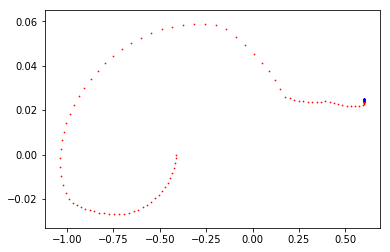

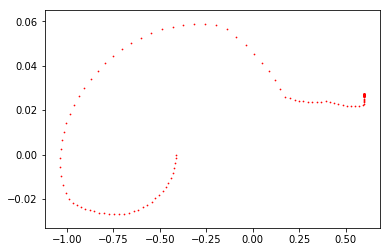

In [29]:
trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = \
train_pipeline(agent_temp, train_trajs = trajs_, paths = None, num_epoch = 100)
x0s = []
for i_traj in range(len(trajs_)):
    x0s.append(trajs_[i_traj][0][0])
agent_trajs = agent_run(agent_temp, x0s)
draw_trajs(agent_trajs)

In [30]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack, linalg
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

epoch_init = 0
num_epoch = 10
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

x0s = []
for i_traj in range(len(trajs)):
    x0s.append(trajs[i_traj][0][0]) 


def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

Done. 1 paths


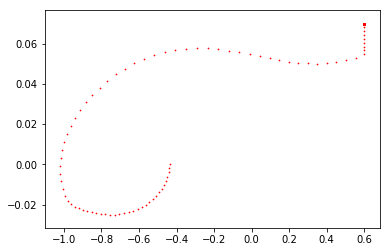

In [31]:
policy_net, _, running_state = pickle.load(open(\
"/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCarContinuous-v0_ppo.p", "rb"))

agent_0 = NeuralNetwork(input_size = 2, output_size = 1, \
                        model_name = 'mountaincar_ppo', \
                        batch_size = 10)
agent_0.model = policy_net.to(device)

agent_trajs = agent_run(agent_0, x0s) 
print("Done. {} paths".format(len(agent_trajs)))
draw_trajs(agent_trajs)
#replay(agent_0, agent_trajs)


Done. 1 paths


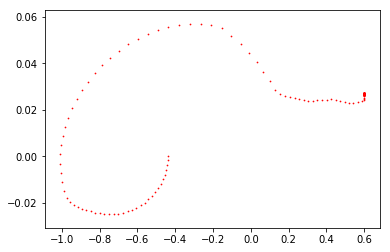

'\n# Run MPSC guided controller and generate safe trajectory\ntraj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)\ndraw_agent_traj(traj)\ndraw_str(nn_traj, mpc_traj)\n\n# Collect training trajectory\ntrain_traj_aggr = [i for i in train_traj[:]] * 100\nitr = 0\n\nwhile itr < 1:\n    train_traj = train_temp(agent, x0s, train_traj_aggr, paths = None)\n    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100\n    itr += 1\n'

In [32]:

agent_1 = NeuralNetwork(input_size = 2, \
                      output_size = 1, \
                      model_name = 'mountaincar_ppo_MPSC', \
                      batch_size = 10)
agent_1.model = policy_net.to(device)
checkpoint_1 = torch.load('checkpoints/mountaincar_ppo_temp.pt')
agent_1.model.load_state_dict(checkpoint_1['model_state_dict'], strict = False)


agent_trajs = agent_run(agent_1, x0s) 
print("Done. {} paths".format(len(agent_trajs)))
draw_trajs(agent_trajs)
#replay(agent_1, agent_trajs)


'''
# Run MPSC guided controller and generate safe trajectory
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)
draw_agent_traj(traj)
draw_str(nn_traj, mpc_traj)

# Collect training trajectory
train_traj_aggr = [i for i in train_traj[:]] * 100
itr = 0

while itr < 1:
    train_traj = train_temp(agent, x0s, train_traj_aggr, paths = None)
    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100
    itr += 1
'''


In [206]:
def QP(P_qp, q_qp, G_qp, h_qp, A_qp = None, b_qp = None):
    P_qp = numpy_sparse_to_spmatrix(P_qp)
    q_qp = matrix(q_qp)
    G_qp = numpy_sparse_to_spmatrix(G_qp)
    h_qp = matrix(h_qp)
    print("Starting solving QP")
    solvers.options['feastol'] = 1e-5
    sol=solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
    #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
    theta_diffs = list(sol['x'])
    if theta_diffs is None:
        theta_diffs = np.zeros(agent.num_parameters(agent.model))
    return theta_diffs


data_trajs = agent_trajs

num_epoch = 5
tol = 1e-5

for epoch in range(num_epoch):
    print(">>>>>>>>>>>>>>>>>>>>")
    print("Start epoch {}".format(epoch))
    # Initialize Q matrix 
    Q1 = []
    Qx = []
    Qu = []
    Qx_T = []
    Qu_T = []
    Qxx = []
    Quu = []
    Qux = []
    Qxu = []

    # Initialize K, k
    K = []
    k = []

    # Run the latest model and original model to get (pi_\theta - u^*)
    u_diffs = []
    # Run the latest model to get gradient on the input x   
    pix = []
    # Run the latest model to get gradient on \theta
    pitheta = []

    # Barrier 1st order and 2nd order
    b1 = []
    bx = []
    bx_T = []
    bxx = []

    xs_diff = []
    us_diff = []
        
    h_qp = []
    G_qp = []
    
    theta_diffs = np.zeros([len(data_trajs), agent.num_parameters(agent.model)])
    P_qp = np.eye(agent.num_parameters(agent.model))
    q_qp = np.zeros([agent.num_parameters(agent.model), 1])
    
    num_itr = 10
    
    for i_traj in range(len(data_trajs)):
        print("Optimize rajectory {}".format(i_traj))
        Q1.append(np.empty([len(data_trajs[i_traj]), 1, 1]))
        Qx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1])) 
        Qu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        Qx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size])) 
        Qu_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.action_size]))
        Qxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))
        Quu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.action_size]))
        Qux.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        Qxu.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))

        # Initialize K, k
        K.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        k.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        # Run the latest model and original model to get (pi_\theta - u^*)
        u_diffs.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        # Run the latest model to get gradient on the input x   
        pix.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))
        # Run the latest model to get gradient on \theta
        pitheta.append(np.empty([len(data_trajs[i_traj]), \
                                 agent.num_parameters(agent.model), dynamics.action_size]))

        # Barrier 1st order and 2nd order
        b1.append(np.empty([len(data_trajs[i_traj]), 1]))
        bx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        bx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size]))
        bxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))

        xs_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        us_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        h_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size, 1]))
        G_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size , \
                              agent.num_parameters(agent.model)]))
        
        data_traj_opt = data_trajs[i_traj][:]
        J_opt = float('inf')
        converged = False
        
        alphas = 0.9**(np.arange(num_itr)**2)
        mus = 1.1**(np.arange(num_itr)**2)
        
        for i_itr in range(num_itr**2):
            alpha = alphas[int(i_itr/num_itr)]
            mu = mus[int(i_itr%num_itr)] 
            
            data_traj = data_trajs[i_traj][:]
            x_new = np.reshape([i for i in data_traj[0][0][:4]], [dynamics.state_size, 1])
            
            data_traj_tmp = []
            xs = []
            us = []
            
            agent.optimizer.zero_grad()
            J_new = 0.0
            
            for i_xy in range(len(data_traj)):
                x_y = data_traj[i_xy]
                x = np.reshape([i for i in x_y[0][:dynamics.state_size]], [dynamics.state_size, 1])
                u = np.reshape([i for i in x_y[1][:]], [dynamics.action_size, 1])

                x_u = x - np.reshape(barrier_u(x_y[0][:dynamics.state_size]), x.shape)
                x_l = x - np.reshape(barrier_l(x_y[0][:dynamics.state_size]), x.shape)

                b1[i_traj][i_xy] = q1[0] * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) - q1[0]\
                        + q1[1] * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) - q1[1]
                bx[i_traj][i_xy] = q1[0] * q2[0]\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T + q1[1] * q2[1]\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T
                
                bx_T[i_traj][i_xy] = bx[i_traj][i_xy].T

                bxx[i_traj][i_xy] = q1[0] * q2[0]**2\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T * A[0]\
                    + q1[1] * q2[1]**2\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T * A[1]

                i = abs(int(x[0]/0.5))
                x_nn = []
                for j in [x[:, 0]]:
                    for e in j:
                        x_nn.append(e)
                        
                x_nn = np.asarray(x_nn)
                x_input = torch.tensor([x_nn], requires_grad = True).to(agent.device)   
                u_output = agent.model(x_input)[0]
                
                for i in range(dynamics.action_size):
                    # Get gradient w.r.t input x[0:4] <<<< pix 
                    pix[i_traj][i_xy, :, i] = torch.autograd.grad(\
                    u_output[i], x_input, retain_graph = True)[0].cpu().numpy().T[0:dynamics.state_size, 0]

                    # Get gradient w.r.t model parameters theta <<<< g_theta
                    torch.autograd.backward(u_output[i], retain_graph = True)
                    j = 0
                    for theta in agent.model.parameters():
                        pitheta_ = theta.grad.data.flatten()
                        pitheta[i_traj][i_xy, j : j + pitheta_.size()[0], i] = pitheta_.cpu().numpy()
                        j += pitheta_.size()[0]    

                u_output = u_output.detach().cpu().numpy()
                u_output = np.reshape(u_output, [dynamics.action_size, 1])

                u_0 = agent_0.run(tensor([x_nn]).to(agent.device))[0]
                u_0 = np.reshape(u_0, [dynamics.action_size, 1])

                u_diffs[i_traj][i_xy] = u_output - u_0

                Q1[i_traj][i_xy] = 4 * b1[i_traj][i_xy]
                Qx[i_traj][i_xy] = -2 * pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy]) + \
                                    2 * bx[i_traj][i_xy]
                Qx_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T) + \
                                    2 * bx[i_traj][i_xy].T
                Qu[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy]
                Qu_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T

                Qxx[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(\
                                    u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T)) + 2 * bxx[i_traj][i_xy]
                Quu[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T) + \
                            mu * np.eye(Quu[i_traj][i_xy].shape[0])
                Qux[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T))
                Qxu[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(u_diffs[i_traj][i_xy].T)

                K[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qux[i_traj][i_xy])
                k[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qu[i_traj][i_xy])

                x_diff = x_new - x

                us_diff[i_traj][i_xy] = alpha * k[i_traj][i_xy] + K[i_traj][i_xy].dot(x_diff)
                xs_diff[i_traj][i_xy] = x_diff
                
                u_new = u_output + us_diff[i_traj][i_xy]
                u_new = u_new.flatten().tolist()
                x_new = x_new.flatten().tolist()
                
                data_traj_tmp.append([x_new, u_new])
                xs.append(x_new)
                us.append(u_new)

                if i_xy < len(data_traj) - 1:
                    x_new = dynamics.f(xs[-1], us[-1], i_xy)[0]
                    x_new = np.reshape(x_new, x.shape)

            
            if (np.squeeze((np.asarray(xs) - \
                np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - \
                           b[0,0] <= 0)).all() == True and \
               (np.squeeze((np.asarray(xs) - \
                np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - \
                           b[1,0] <= 0)).all() == True:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Safe]".format(i_itr))
                #draw_agent_traj([data_traj_tmp])
                
                # Calculate J_new
                
                '''
                # Option 1: Directly calculate the loss of the QP
                for i_xy in range(xs_diffs[i_traj].shape[0]):                    
                    J_new += np.sum(Q1[i_traj][i_xy] + \
                                    2 * xs_diff[i_traj][i_xy].T.dot(Qx[i_traj][i_xy]) + \
                                    2 * us_diff[i_traj][i_xy].T.dot(Qu[i_traj][i_xy]) + \
                                    2 * (xs_diff[i_traj][i_xy].T.dot(Qxu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]) + \
                                    (xs_diff[i_traj][i_xy].T.dot(Qxx[i_traj][i_xy])).dot(xs_diff[i_traj][i_xy]) + \
                                    (us_diff[i_traj][i_xy].T.dot(Quu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]))
                '''
                # Option 2: Calculate the loss of the original model on the new trajectory(s)
                #           The input to the original model should be rebuilt for every single state
                for i_xy in range(xs_diff[i_traj].shape[0]):
                    x = data_trajs[i_traj][i_xy][0]
                    u = data_trajs[i_traj][i_xy][1]
                    
                    x_ = np.asarray(x) + xs_diff[i_traj][i_xy].flatten()
                    i_ = abs(int(x[0]/0.5))
                    x_nn_ = []
                    for j_ in [x_]:
                        for k_ in j_:
                            x_nn_.append(k_)
                    
                    u_ = np.asarray(u) + us_diff[i_traj][i_xy].flatten()
                    u_0 = agent_0.run(tensor([x_nn_]).to(agent.device))[0]
                    J_new += np.linalg.norm(np.asarray(u_) - np.asarray(u_0), ord = 2 )
                    
                
                if J_opt > J_new:
                    if np.abs((J_opt - J_new)/J_opt) < tol:
                        converged = True
                        print("Converged.")
                        break
                    print("Found new optimal solution. Load QP parameters.")
                    for i_xy in range(len(data_traj)):
                        h_i = (us_diff[i_traj][i_xy].T - xs_diff[i_traj][i_xy].T.dot(pix[i_traj][i_xy])).T
                        G_i = pitheta[i_traj][i_xy].T

                        for j in range(dynamics.action_size):
                            h_qp[i_traj][i_xy + j, :] = h_i[j, 0]
                            G_qp[i_traj][i_xy + j, :] = G_i[j, :]
                    J_opt = J_new
                    data_traj_opt = data_traj_tmp[:]
                    
                #alpha = 1.1 * (1.0 + 0.9**i_itr) * alpha 
                #mu = 0.9 * (1.0 - 0.9**i_itr) * mu
                
            else:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Unsafe]".format(i_itr))  
                #draw_agent_traj([data_traj_tmp])
                #alpha = 0.9 * (1 - 0.9**i_itr) * alpha
                #mu = 1.1 * (1 + 0.9**i_itr) * mu 
        
        data_trajs[i_traj] = data_traj_opt[:]
        draw_trajs([data_traj_opt])
    
    
    pickle.dump((G_qp, h_qp), open('linear_eq.p', 'wb'))
    '''
    # Update the model
    
    # Option 1
    # Solve the perturbations on the model parameters with minimal norm via QP
    # Each newly generated trajecotry corresponds to a perturbation
    # Use the average as the final result
    #for i_traj in range(len(theta_diffs)):  
    #    theta_diffs[i_traj] = np.asarray(QP(P_qp, q_qp, G_qp[i_traj], h_qp[i_traj]))
    #theta_diffs = np.mean(theta_diffs, axis = 0)
    
    # Option 2
    # Solve the perturbations on the model parameters with minimal norm via QP
    # All newly generated trajecotries are included in one constraint
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = np.asarray(QP(P_qp, q_qp, G_qp, h_qp))
    
    # Option 3
    # Solve the perturbation on the model parameters via one linear equation
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = linalg.cgs(G_qp.T.dot(G_qp), G_qp.T.dot(h_qp))[0]
    #theta_diffs = np.linalg.solve(G_qp.T.dot(G_qp) + np.eye(G_qp.shape[1]), G_qp.T.dot(h_qp))
    
    # Modify the model parameters by hand
    i = 0
    for theta in agent.model.parameters():
        theta.data += torch.FloatTensor(\
            np.reshape(theta_diffs[i: i + theta.data.numel()], theta.data.size())).to(agent.device)
        i += theta.data.numel()
    
    ''' 
    
    train_trajs = [[i for i in traj] for traj in data_trajs]
    while True:
        num_interv = 0
        data_trajs, nn_trajs, mpc_trajs, train_trajs  = train_pipeline(agent, x0s, train_trajs, paths = None)
        for i_traj in range(len(mpc_trajs)):
            num_interv += len(mpc_trajs[i_traj])
        if num_interv == 0:
            print("No intervention. Agent is clear.")
            break
        print("Intervention identified. Retrain agent in the pipeline.") 
        train_trajs = data_to_train(data_trajs)
        
    data_trajs = agent_run(agent, x0s)
    draw_agent_traj(data_trajs)
    print("<<<<<<<<<<<<<<<<<<<<")
    print("Finished epoch {}\n\n\n\n".format(epoch))
        

>>>>>>>>>>>>>>>>>>>>
Start epoch 0
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]


KeyboardInterrupt: 